Ingeniería de Software Basada en la Nube

#  Unidad 6 - Laboratorio
__________________


## Objetivos

**1.** Configurar un ambiente local de Terraform y cliente de Google Cloud.

**2.** Desplegar la infraestructura necesaria para los cuatro componentes del laboratorio de la Unidad 4.

**3.** Desplegar automáticamente un componente sobre un elemento de infraestructura.



# Parte 1: Pre-requisitos





**1.** Instalación de Terraform. Seguir las instrucciones en [este enlace](https://developer.hashicorp.com/terraform/install) o ver [este video](https://www.youtube.com/watch?v=dA6WqakJOts&ab_channel=CloudTech).


Validar la instalación con el siguiente comando:

```
terraform --version
```

La salida debería ser similar a:

```
Terraform v1.9.8
on windows_amd64
```

La versión puede variar según el sistema operativo y la versión instalada de Terraform.

**2** Instalación de la CLI de GCP. Seguir las instrucciones en [este enlace](https://cloud.google.com/sdk/docs/install).

Validar la instalación con el siguiente comando:

```
gcloud --version
```
Si la CLI de Google Cloud está instalada correctamente, se verá la versión de gcloud, junto con las versiones de otros componentes instalados. La salida será algo similar a:

```
Google Cloud SDK X.XX.X
bq X.XX.X
core X.XX.X
gsutil X.XX.X

```

Para configurar la CLI después de instalarla, si es la primera vez que se usa, ejecutar:

```
gcloud init
```
Este comando ayudará a configurar y a autenticar la cuenta de Google en la CLI.

**3** Instalación de Docker (en caso de no tenerlo). Seguir las instrucciones en [este enlace](https://docs.docker.com/desktop/install/windows-install/).

Para validar que Docker está instalado en el sistema, ejecutar el siguiente comando en una terminal:

```
docker --version
```

Si Docker está instalado, se verá la versión en la salida, algo similar a:

```
Docker version XX.XX.X, build XXXXXXX
```

**4** Instalación de Git. Seguir las instrucciones en [este enlace](https://github.com/git-guides/install-git)


Para verificar si Git está instalado, ejecutar este comando en una terminal:

```
git --version
```

Si Git está instalado, se verá un mensaje con la versión, similar a:

```
git version X.XX.X
```

**5** Crear la imagen de Docker para el componente #2 (isbn-users-ms) del laboratorio de la Unidad 4.

Para verificar si una imagen de Docker específica existe localmente en tu sistema, usar el siguiente comando en la terminal:

```
docker images
```
Esto mostrará una lista de todas las imágenes disponibles en la máquina. Buscar en la columna REPOSITORY el nombre de la imagen y en la columna TAG la versión o etiqueta.

# Parte 2: Clonar esquema de Infraestructura como Codigo (IaC)

El material para este laboratorio esta disponible en un repositorio de código público en [este enlace](https://github.com/camilonfs1/IaC-laboratory).

Clonar el repositorio ejecutando el siguiente comando:

```
git clone https://github.com/camilonfs1/IaC-laboratory.git
```



Dentro del directorio se encontrarán los siguientes elementos:
    
    - modules/
    - main.tf
    - terraform.tfvars
    - variables.tf

# Parte 3: Estructura del Esquema de IaC

1. Directorio **modules**

Contiene módulos reutilizables que agrupan configuraciones de infraestructura, como instancias o redes. Facilita la organización y la reutilización del código.

Dentro de este directorio se encontrará un grupo de elementos de infraestructura y configuraciones requeridas para el funcionamiento de los componentes del laboratorio de la unidad 4.

    Elementos de infraestructura :
    - CloudFunction/
    - CloudRun/
    - CloudSQL/
    - Registry/
    - Firestore/
    Configuraciones necesarias :
    - Apis/
    - DockerCommads/


2. Archivo **main.tf**

Archivo principal donde se define la infraestructura que se desea crear. Incluye proveedores, recursos y llamadas a módulos.


```
# Proveedor de Google Cloud
provider "google" {
  project = var.project_id  # ID del proyecto de Google Cloud
  region  = "us-east4"      # Región donde se desplegarán los recursos
}

# Módulo para habilitar APIs
module "APIs" {
  source     = "./modules/apis"  # Ruta al módulo que habilita las APIs necesarias
  project_id = var.project_id      # ID del proyecto utilizado en el módulo
}

# Módulo para configurar una base de datos Cloud SQL
module "Database" {
    source = "./modules/CloudSQL"  # Ruta al módulo que configura Cloud SQL
    database_name = var.database_name  # Nombre de la base de datos
    region = var.region                # Región donde se creará la base de datos
    depends_on = [module.APIs]        # Asegura que el módulo de APIs se ejecute primero
}

# Módulo para crear un registro (Registry)
module "Registry" {
    source = "./modules/Registry"     # Ruta al módulo del registro
    depends_on = [module.APIs]        # Asegura que el módulo de APIs se ejecute primero
}

# Módulo para ejecutar comandos de Docker
module "docker_commands" {
    source = "./modules/DockerCommands"  # Ruta al módulo de comandos Docker
    depends_on = [module.Registry]        # Asegura que el módulo de Registry se ejecute primero
}

# Módulo para desplegar servicios en Cloud Run
module "CloudRun" {
  source = "./modules/CloudRun"        # Ruta al módulo de Cloud Run
  region = var.region                   # Región donde se desplegará el servicio

  # Espera a que la imagen esté disponible antes de crear el servicio
  depends_on = [module.APIs, module.docker_commands]  # Asegura que se completen las APIs y comandos Docker
}

# Módulo para configurar Firestore
module "Firestore" {
    source = "./modules/Firestore"     # Ruta al módulo de Firestore
    region = var.region                 # Región donde se creará Firestore
    depends_on = [module.APIs]         # Asegura que el módulo de APIs se ejecute primero
}

# Módulo para desplegar funciones en la nube
module "CloudFunction" {
    source = "./modules/CloudFunction"  # Ruta al módulo de funciones en la nube
    region = var.region                  # Región donde se desplegará la función
    project_id = var.project_id          # ID del proyecto utilizado en el módulo
    depends_on = [module.APIs]          # Asegura que el módulo de APIs se ejecute primero
}
```

3. Archivo **terraform.tfvars**

Archivo para especificar los valores de las variables definidas en *variables.tf*. Permite ajustar configuraciones sin modificar el código principal.

```
region = "us-east4"
database_name = "data_base_name"
project_id = "isbn-2024ii"
```



4. Archivo **variables.tf**

Archivo donde se declaran las variables utilizadas en la configuración de Terraform, especificando su tipo y valores predeterminados.

```
# Variable que define la región donde se desplegarán los recursos
variable "region" {
    type    = string      # Tipo de la variable (cadena de texto)
    default = "region"    # Valor predeterminado para la región
}

# Variable que define el nombre de la base de datos
variable "database_name" {
    type        = string  # Tipo de la variable (cadena de texto)
    description = "nombre de la base de datos"  # Descripción que explica el uso de la variable
}

# Variable que define el ID del proyecto en Google Cloud
variable "project_id" {
    type = string  # Tipo de la variable (cadena de texto)
}

```

# Parte 4: Comprender Módulos



Los módulos en Terraform son bloques de configuración reutilizables que agrupan recursos y definiciones relacionadas. Permiten encapsular lógica de infraestructura, facilitando la organización y la reutilización del código. Se pueden usar módulos locales o remotos, y se les pueden pasar parámetros a través de variables para personalizar su comportamiento, lo que simplifica la gestión y el mantenimiento de la infraestructura.

En este caso se cuenta con módulos para elementos de infraestructura y para configuraciones dentro del directorio *modules/*.

    Elementos de infraestructura :
    - CloudFunction/
    - CloudRun/
    - CloudSQL/
    - Registry/
    - Firestore/
    Configuraciones necesarias :
    - Apis/
    - DockerCommads/

Cada módulo tiene un archivo **main.tf** que contiene el esquema de IaC propio del elemento de infraestructura que se va a crear, por ejemplo una base de datos Cloud SQL:

```
# Crear una instancia de Cloud SQL (MySQL 8.0) con edición Enterprise
resource "google_sql_database_instance" "isbn_users_db" {
  name             = "isbn-users-db"              # Nombre de la instancia de base de datos, asignado desde la variable
  database_version = "MYSQL_8_0"                  # Versión de MySQL especificada: 8.0
  region           = var.region                   # Región donde se despliega la instancia, asignada desde la variable

  settings {
    tier = "db-custom-1-3840"                     # Configuración de Sandobox, se puede ajustar el tamaño si es necesario

    backup_configuration {
      enabled = true                              # Habilitar las copias de seguridad automáticas
    }

    ip_configuration {
      ipv4_enabled = true                         # Habilitar IP pública para la instancia
    }

    availability_type = "ZONAL"                # Configuración para disponibilidad en una sola zona    
  }
  deletion_protection = false
}

# Crear una base de datos en la instancia
resource "google_sql_database" "default" {
  name       = var.database_name                    # Nombre de la base de datos dentro de la instancia
  instance   = google_sql_database_instance.isbn_users_db.name  # Referencia a la instancia de Cloud SQL creada
  charset    = "utf8"                             # Conjunto de caracteres para la base de datos
  collation  = "utf8_general_ci"                  # Configuración de collation (predeterminada para UTF-8 en MySQL)
}

# Crear un usuario para la instancia con acceso desde cualquier host
resource "google_sql_user" "isbn_user" {
  name     = "isbn"                               # Nombre del usuario de la base de datos
  instance = google_sql_database_instance.isbn_users_db.name  # Referencia a la instancia de Cloud SQL creada
  password = "123"                                # Contraseña para el usuario (considerar almacenarla de forma segura)
  host     = "%"                                  # Permitir acceso desde cualquier host
}
```

En este fragmento de código se describre detalladamente cada una de las características y configuraciones que se requieren para el funcionamiento de este elemento en particular. Los cuales son extraidos del laboratorio de la unidad 4.

Además los módulos pueden tener otros archivos, como el de **variables.tf** que en este caso contiene el nombre de la base de datos y la región de GCP en la cual se va a crear:

```
variable "database_name" {
    type = string  
}

variable "region" {
    type = string  
}
```

# Parte 5_ Desplegar Infraestructura en GCP

Para que este proceso de despliegue automatizado de infraestructura se desarrolle satisfactoriamente es indispensable tener GCP CLI autenticado como se solicitó en la Parte 1.

Los comandos de Terraform son herramientas fundamentales que permiten a los usuarios interactuar con su infraestructura, facilitando la inicialización, planificación, aplicación y destrucción de recursos en un entorno controlado y reproducible.

1. terraform init

```
terraform init
```

Este comando inicializa un directorio de trabajo de Terraform. Crea la estructura necesaria y descarga los proveedores especificados en la configuración. Es el primer comando que se debe ejecutar antes de trabajar con Terraform en un nuevo proyecto.

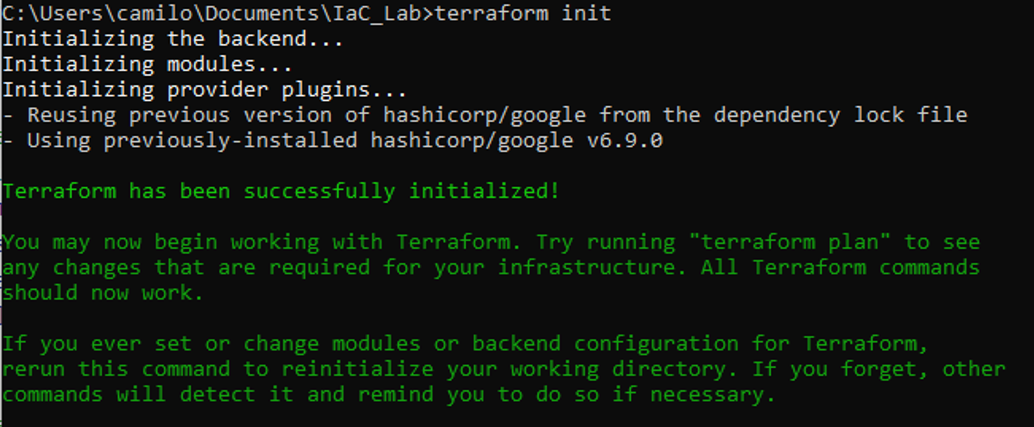


2. terraform plan

```
terraform plan
```

Genera un plan de ejecución que muestra las acciones que Terraform realizará para alcanzar el estado deseado de la infraestructura, según la configuración actual. No realiza cambios; solo permite revisar lo que sucederá.

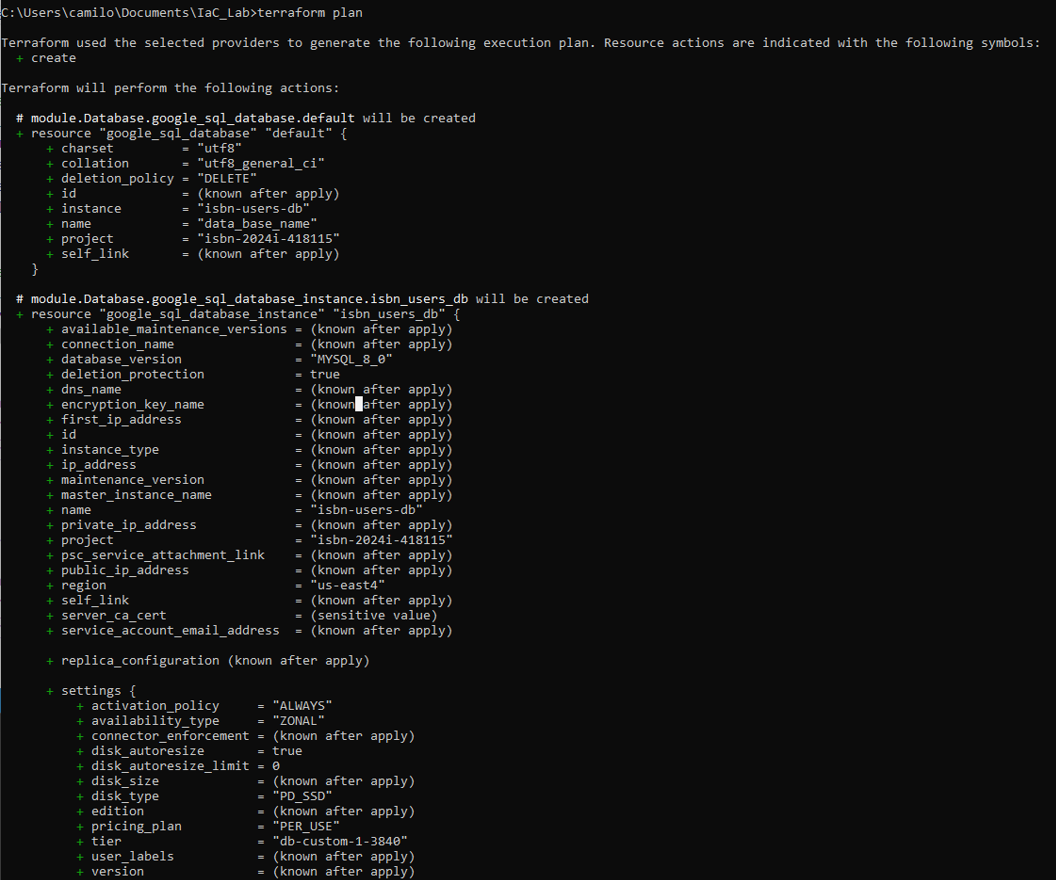

3. terraform apply

```
terraform apply
```

Aplica los cambios necesarios para alcanzar el estado deseado de la infraestructura. Ejecuta las acciones que se mostraron en el plan. Puede requerir confirmación antes de proceder.

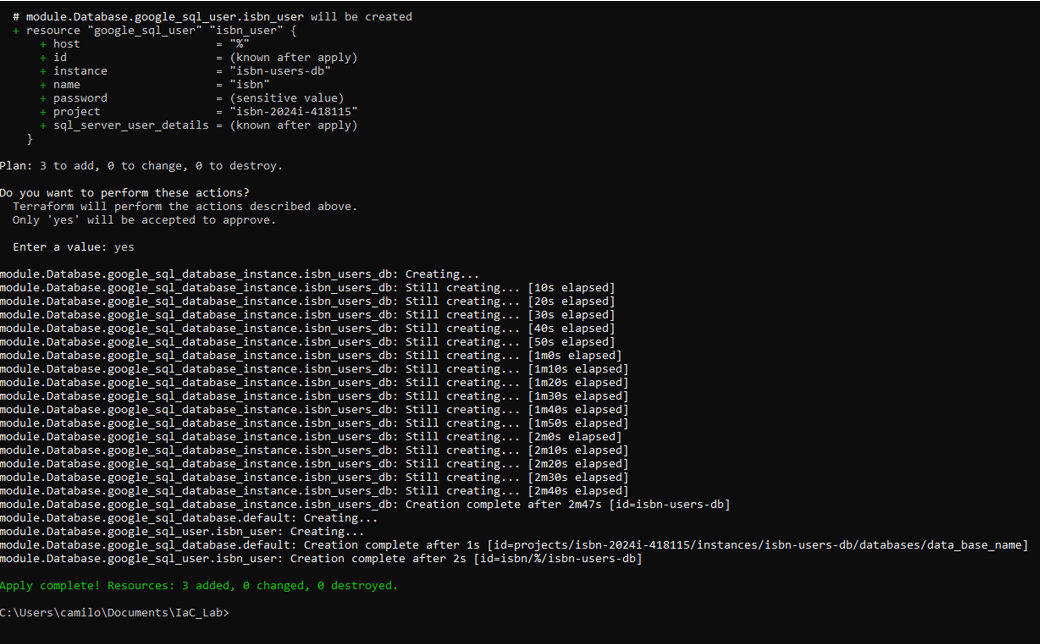



# Parte 6: Remoción de la Infraestructura

Utilizando IaC con Terraform se puede remover la infraestructura previamente creada con un comando que automaticamente destruye todos los elementos de infraestructura que se tengan descritas en el esquema de IaC.

```
terraform destroy
```

Una vez ejecutado este comando se tendrá el siguiente resultado esperado:

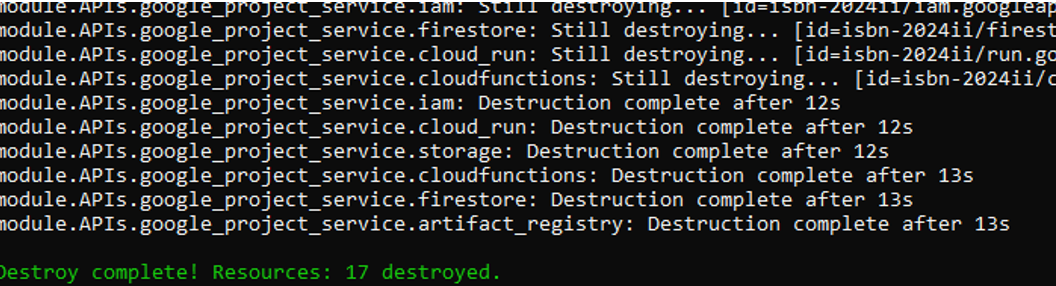